# Spreadsheet GIXD

# Functions

In [37]:
import PyNexus as PN #use version >= 4.1
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import numpy as np
import os
from PIL import Image


def extract_images_PILATUS(nexus):
    """
    Input: the nexus file.
    Output: an array with the size [nbimages, 1043, 981].
    1) Extract all the full images from a scan with the PILATUS as the sensor.
    2) Remove the dead pixels
    3) Replace the dead zones with 0.
    """
    
    #Find the stamp of the pilatus in the Nexus file
    stamps = nexus.extractStamps()
    for i in range(len(stamps)):
        if (stamps[i][1] != None and stamps[i][1].lower() == "pilatus"):
            i_pilatus = i


    #Number of images taken during the scan
    nbimages = nexus.get_nbpts()
    print("There are %g images in the scan"%(nbimages))

    images = np.zeros([nbimages, 1043, 981])

    for i in range(nbimages):

        #Extract the images from the nexus file
        stamp, image = nexus.extract_one_data_point(stamps[i_pilatus][0], i, verbose = False)

        #Remove the dead pixels

        image[877,528]=0.0
        image[922,847]=0.0
        image[1018,881]=0.0
        image[382,432]=0.0
        image[640,859]=0.0
        image[640,860]=0.0


        #Replace the dead zone (spacing between chips) on the detector with 0. 
        image = np.where(image>0, image, 0.)

        images[i,:] = image
        
    return images


def export2_dat(file):
    """
    Works for any type of scan.  
    Convert a scan of N points with M sensors into a txt file of N rows and M columns,  
    with at each position NxM the value of the sensor M at the point N of the scan.
    """
    
    print(file)
    nexus = PN.PyNexusFile(file, fast=True)

    stamps, data = nexus.extractData('0D')
    nexus.savePointExtractedData((stamps, data))
    print("Saved as %s"%(file.split('.')[0]+'.dat'))
    print("")
    

def export2_pilatus_sum(file, issave = False, isprint = True):
    """
    Works ideally for a time scan of a fixed configuration.  
    Sum all the images of the scan.  
    Save the result as a table of 1043 rows 981 columns in ascii (.mat) and in tiff.
    """

    print(file)
    ##################################################
    #Import all the full images of the scan first

    nexus = PN.PyNexusFile(file, fast=True)

    images = extract_images_PILATUS(nexus)

    images_sum = images.sum(axis=0)

    if isprint:
        #Plot the image to be saved
        #Choose the colormap
        cmap = 'Greys'
        #cmap = 'viridis'

        fig = plt.figure(figsize=(12,12))
        plt.imshow(images_sum, cmap = cmap, norm=colors.LogNorm())
        plt.title('Sum of all images of scan %s'%file)
        plt.xlabel('Horizontal pixel (x)')
        plt.ylabel('Vertical pixel (y)')
        plt.show()
        plt.close()

    if issave:
        filename_save = file.split('.')[0]
        np.savetxt(filename_save+'_pilatus_sum.mat', images_sum)
        print("Saved as %s"%(filename_save+'_pilatus_sum.mat'))

        im = Image.fromarray(images_sum)
        im.save(filename_save+'_pilatus_sum.tiff')
        print("Saved as %s"%(filename_save+'_pilatus_sum.tiff'))
    

def export2_1Dmatdatmoy(file, issave = False, isprint = False, isprinter = False):
    """  
    Made for diffraction scans with Soller slits.  
    Defines a ROI around the Soller slits [510, 350, 130, 692].  

    XXX_1D.mat:  
    For the N images of the scan, sums over the horizontal axis of the ROI image.  
    Saves the results as a table of N rows and 692 columns in ascii (.mat).

    XXX_1D.mat10, XXX_1D.mat20, XXX_1D.mat40:  
    Binning of the images of XXX_1D.mat.  
    Saves the results as a table of N rows and int(692//binning) columns in ascii (.mat).  
    For example, for binning 10, N rows and 69 columns.

    XXX_1D.dat:  
    For the N images of the scan, sums over the full ROI, sums over the bottom-half of the ROI, sums over the top-half of the ROI.  
    Saves the results as a table of N rows. 1st column is qxy in nm^-1, 2nd column is the full ROI summed, 3rd column is th bottom-half of the ROI summed, 4th column is the top-half of the ROI summed.

    XXX_1D.moy10, XXX_1D.moy20, XXX_1D.moy40:
    Binning of the matrix (qxy, ROI vertical axis).
    Results are saved as 1st column: value of qxy, 2nd column: vertical axis of the ROI, with spacing depending on the value after .moy., 3rd column: ROI summed of XXX_1D.mat summed.
    """            

    print(file)
    ##################################################
    #Import all the full images of the scan first

    nexus = PN.PyNexusFile(file, fast=True)

    images = extract_images_PILATUS(nexus)

    #Define the ROI on the pilatus
    #ROI = [x0, y0, size_x, size_y]
    #Full image: ROI = [0, 0, 981, 1043]

    ROI=[510, 350, 130, 692] #Good ROI for Sollers' slits

    #Apply the ROI
    ROIimages = images[:,ROI[1]:ROI[1]+ROI[3], ROI[0]:ROI[0]+ROI[2]]
    
    
    ##########################################################################
    #Save into XXX_1D.mat

    #Sum over the x (horizontal) axis of each image 
    ROIimages_sumx = ROIimages.sum(axis=2)

    if isprint:
        fig = plt.figure(figsize=(12,12))
        plt.imshow(ROIimages_sumx, cmap = 'viridis', norm=colors.LogNorm())
        plt.xlabel('Vertical pixel (y)')
        plt.ylabel('Point number from the scan')
        plt.show()
        plt.close()

    if issave:
        filename_save = file.split('.')[0]
        np.savetxt(filename_save+'_1D.mat', ROIimages_sumx)
        print("Saved as %s"%(filename_save+'_1D.mat'))
    
    ##########################################################################
    #Save into XXX_1D.mat10, XXX_1D.mat20, XXX_1D.mat40

    binnings = [10, 20, 40]

    for binning in binnings:
        ROIimages_sumx_bin = np.zeros((np.shape(ROIimages_sumx)[0],int(np.shape(ROIimages_sumx)[1]//binning)))

        for i in range(np.shape(ROIimages_sumx)[0]):
            for j in range(0, np.shape(ROIimages_sumx)[1]-binning, binning):
                ROIimages_sumx_bin[i,j//binning] = ROIimages_sumx[i,j:j+binning].sum()

        if isprint:
            fig = plt.figure(figsize=(12,12))
            plt.imshow(ROIimages_sumx_bin, cmap = 'viridis', norm=colors.LogNorm())
            plt.title('Binning %g'%binning)
            plt.xlabel('Vertical pixel (y)/%g'%binning)
            plt.ylabel('Point number from the scan')
            plt.show()

        if issave:
            filename_save = file.split('.')[0]
            np.savetxt(filename_save+'_1D.mat'+str(binning), ROIimages_sumx_bin)     
            print("Saved as %s"%(filename_save+'_1D.mat'+str(binning)))

    ##########################################################################
    #Save into XXX_1D.moy10, XXX_1D.moy20, XXX_1D.moy40

    binnings = [10, 20, 40]

    #Sum over the x (horizontal) axis of each image 
    ROIimages_sumx = ROIimages.sum(axis=2)

    #Find the stamp in the Nexus file
    stamps = nexus.extractStamps()
    for i in range(len(stamps)):
        if (stamps[i][1] != None and stamps[i][1].lower()=='qxy'):
            i_qxy = i

    #Extract the values of each elements of the nxs
    s, data = nexus.extractData('0D')

    for binning in binnings:

        nb_bins =  int(np.shape(ROIimages)[1]//binning)

        ROIimages_moy = np.zeros((np.shape(ROIimages)[0]*nb_bins, 3))

        data_rank = 0
        for i in range(0, np.shape(ROIimages)[0]*nb_bins, nb_bins):
            for j in range(nb_bins):
                ROIimages_moy[i+j, 0] = data[i_qxy][data_rank]
                ROIimages_moy[i+j, 1] = (2*j+1)*binning//2
                ROIimages_moy[i+j, 2] = ROIimages_sumx[data_rank,(2*j)*binning//2:(2*j+2)*binning//2].sum()

            data_rank += 1
        
        if issave:
            filename_save = file.split('.')[0]
            np.savetxt(filename_save+'_1D.moy'+str(binning), ROIimages_moy) 
            print("Saved as %s"%(filename_save+'_1D.moy'+str(binning)))

    ##########################################################################
    #Save into XXX_1D.dat

    #Find the stamp in the Nexus file
    stamps = nexus.extractStamps()
    i_pi = None
    i_gamma = None
    for i in range(len(stamps)):
        if (stamps[i][1] != None and stamps[i][1].lower()=='qxy'):
            i_qxy = i
        if (stamps[i][1] != None and stamps[i][1].lower()=='pressurearea'):
            i_pi = i
        if (stamps[i][1] != None and stamps[i][1].lower()=='gamma'):
            i_gamma = i
            

    #Extract the values of each elements of the nxs
    s, data = nexus.extractData('0D')

    #Sum over the whole ROI for each point of the scan
    ROIimages_sum = ROIimages.sum(axis=1).sum(axis=1)

    #Sum over the bottom-half of the ROI for each point of the scan
    ROIimages_sumbottom = ROIimages[:,:,0:ROI[2]//2].sum(axis=1).sum(axis=1)

    #Sum over the top-half of the ROI for each point of the scan
    ROIimages_sumtop = ROIimages[:,:,ROI[2]//2:].sum(axis=1).sum(axis=1)

    if isprint:
        fig = plt.figure(figsize=(8,8))
        plt.plot(data[i_qxy], ROIimages_sum, '-o', label = 'Full ROI')
        plt.plot(data[i_qxy], ROIimages_sumbottom, '-o', label = 'Bottom-half ROI')
        plt.plot(data[i_qxy], ROIimages_sumtop, '-o', label = 'Top-half ROI')
        plt.xlabel('qxy (nm^-1)')
        plt.ylabel('qz integrated')
        plt.legend()
        plt.show()

    if issave:
        data_to_save = np.array([data[i_qxy], ROIimages_sum, ROIimages_sumbottom, ROIimages_sumtop]).transpose()

        filename_save = file.split('.')[0]
        np.savetxt(filename_save+'_1D.dat', data_to_save)
        print("Saved as %s"%(filename_save+'_1D.dat'))
       

    """
    Generate a nice figure for a diffraction scan
    Difference with Philippe's programm : the detector is not flipped here
    (i.e the bottom of the image is the bottom of the detector)
    """
    
    
    #Generate the heatmap image

    #The effective size of the sum filter is twice the value of filter_size
    filter_size = 5
    ROIimages_sumx_filter = np.zeros(np.shape(ROIimages_sumx))

    for i in range(np.shape(ROIimages_sumx)[0]):
        for j in range(np.shape(ROIimages_sumx)[1]):

            #Exclude the border of the image
            if (j<=filter_size) or (j>=np.shape(ROIimages_sumx)[1]-filter_size+1):
                ROIimages_sumx_filter[i,j] = np.nan

            else:
                #Note that we do an average along the vertical axis only
                ROIimages_sumx_filter[i,j] = ROIimages_sumx[i,j-filter_size:j+filter_size].sum() 



    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)

    ax1.plot(data[i_qxy], ROIimages_sum, '-o')
    ax1.set_xlabel('qxy (nm^-1)')
    ax1.set_ylabel('qz integrated')


    #Plot a profile along yp
    ax2 = fig.add_subplot(122)
    ax2.contourf(data[i_qxy], np.arange(np.shape(ROIimages_sumx)[1]), ROIimages_sumx_filter.transpose(),
                 cmap = 'jet')
    ax2.invert_yaxis()
    ax2.set_xlabel('qxy (nm^-1)')
    ax2.set_ylabel('vertical channels (y)')


    fig.suptitle(file.split('\\')[-1], fontsize=16)

    if i_pi != None:
        mean_pi = np.mean(data[i_pi])
        fig.text(.04, 0., r'$\pi = %3.4g \, mN.m^{-1}$'%(mean_pi), fontsize='large', color='red')

    if i_gamma != None:
        mean_gamma = np.mean(data[i_gamma])
        fig.text(.96, 0., r'$\gamma = %3.4g \,deg$'%(mean_gamma), fontsize='large', color='red', horizontalalignment='right')

    plt.show()

    if isprinter:
        #Work only on windows
        fig.set_size_inches(12,5)
        fig.savefig('.plot.pdf')
        os.startfile(".plot.pdf", "print")


# Show the list of sensors in a scan

In [27]:
file = "SIRIUS_2019_10_06_00568.nxs"
nexus = PN.PyNexusFile(file, fast=True)

In [28]:
#Print the different sensors/motors and their rank
stamps = nexus.extractStamps()
for i in range(len(stamps)):
    if stamps[i][1]==None:
        stamp=stamps[i][0]
    else:
        stamp=stamps[i][1]
    print("\t%d\t--> %s"%(i, stamp))

	0	--> zs
	1	--> m4pitch
	2	--> delta0
	3	--> zs
	4	--> hu36energy
	5	--> basez
	6	--> xs
	7	--> c10tablez_mot
	8	--> current
	9	--> dioderefl
	10	--> mon4i1
	11	--> mon4i2
	12	--> mon4i3
	13	--> mon4i4
	14	--> pilatus
	15	--> pilatusroi1
	16	--> pilatusroi2
	17	--> pilatusroi3
	18	--> pilatusroi4
	19	--> pilatusroi4max
	20	--> c10tablepitch
	21	--> pilatusz1
	22	--> pilatusz2
	23	--> mon2i1
	24	--> mon2i2
	25	--> mon2i3
	26	--> mon2i4
	27	--> integration_time
	28	--> sensorsRelTimestamps
	29	--> sensorsTimestamps
	30	--> i15-c-cx1/ex/v2_grp_zs.pos/pos


# Scan with the PILATUS as a sensor

In [38]:
file = "SIRIUS_2019_10_06_00568.nxs"

nexus = PN.PyNexusFile(file, fast=True)

#Import all the full images of the scan first
images = extract_images_PILATUS(nexus)

There are 41 images in the scan


## Show integrated full image and horizontal/vertical integrations

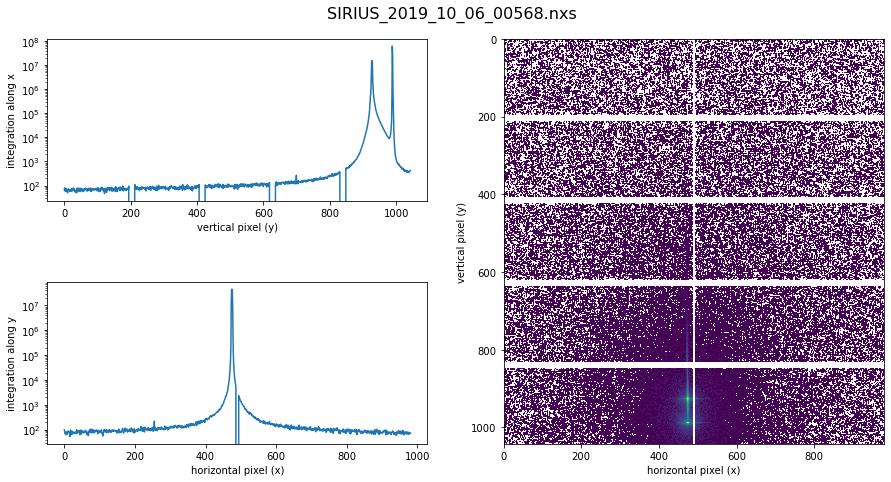

In [43]:
#Choose the colormap
#cmap = 'Greys'
cmap = 'viridis'

pixels_x = np.arange(0,np.shape(images.sum(axis=0))[1],1)
pixels_y = np.arange(0,np.shape(images.sum(axis=0))[0],1)

xx, yy = np.meshgrid(pixels_x, pixels_y)

fig = plt.figure(figsize=(15,15))

#Divide the grid in 2x2
outer = gridspec.GridSpec(2, 2, wspace=0.2)

#Divide the left row in 2x1
inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                subplot_spec=outer[0], hspace=0.5)

#Plot a profile along y (integrated over x)
ax1 = fig.add_subplot(inner[0])
profile_y = images.sum(axis=0).sum(axis=1)
ax1.set_yscale('log')
ax1.set(xlabel = 'vertical pixel (y)', ylabel = 'integration along x')
ax1.plot(profile_y)

#Plot a profile along x (integrated over y)
ax2 = fig.add_subplot(inner[1])
profile_x = images.sum(axis=0).sum(axis=0)
ax2.set_yscale('log')
ax2.set(xlabel = 'horizontal pixel (x)', ylabel = 'integration along y')
ax2.plot(profile_x)


#Divide the right row in 1x1
inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                subplot_spec=outer[1], wspace=0.1, hspace=0.1)

#Show the full image integrated over the scan
ax0 = fig.add_subplot(inner[0])
ax0.pcolormesh(xx, yy, images.sum(axis=0), vmin=1, cmap = cmap, norm = colors.LogNorm())
ax0.invert_yaxis()

ax0.set(xlabel = 'horizontal pixel (x)', ylabel ='vertical pixel (y)')

fig.subplots_adjust(top=0.95)
fig.suptitle(file.split('\\')[-1], fontsize=16)

plt.show()

# Uncomment to print

#fig.set_size_inches(12,12)
#fig.savefig('.plot.pdf')

#os.startfile(".plot.pdf", "print")


## Show integrated full image and line profiles

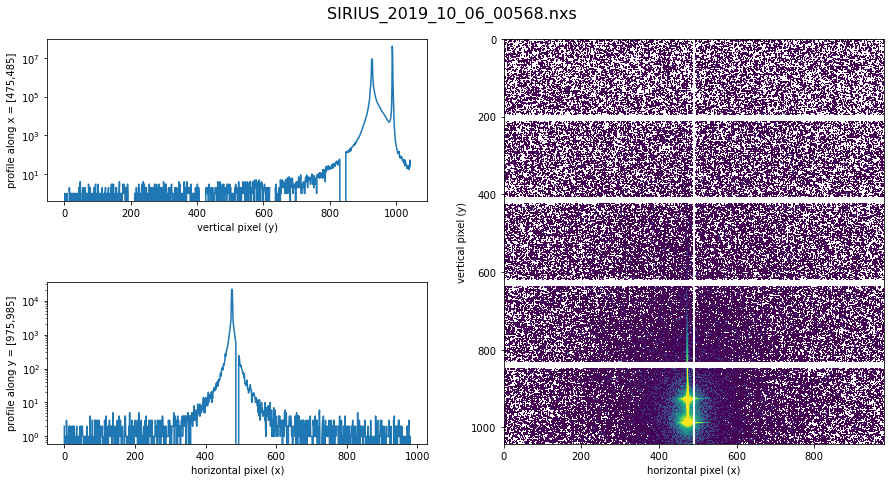

In [44]:
#Choose the pixels along which you wish to integrate
xp = 480
yp = 980

#Choose the thickness of the slice (in pixels, odd numbers only)
th = 11

#Choose the colormap
#cmap = 'Greys'
cmap = 'viridis'

pixels_x = np.arange(0,np.shape(images.sum(axis=0))[1],1)
pixels_y = np.arange(0,np.shape(images.sum(axis=0))[0],1)

xx, yy = np.meshgrid(pixels_x, pixels_y)

fig = plt.figure(figsize=(15,15))

#Divide the grid in 2x2
outer = gridspec.GridSpec(2, 2, wspace=0.2)

#Divide the left row in 2x1
inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                subplot_spec=outer[0], hspace=0.5)

#Plot a profile along xp
ax1 = fig.add_subplot(inner[0])
profile_y = images[:,:,xp-th//2:xp+th//2].sum(axis=0).sum(axis=1)
ax1.set_yscale('log')
ax1.set(xlabel = 'vertical pixel (y)', ylabel = 'profile along x = [%g,%g]'%(xp-th//2,xp+th//2))
ax1.plot(profile_y)

#Plot a profile along yp
ax2 = fig.add_subplot(inner[1])
profile_x = images[:,yp-th//2:yp+th//2,:].sum(axis=0).transpose().sum(axis=1)
ax2.set_yscale('log')
ax2.set(xlabel = 'horizontal pixel (x)', ylabel = 'profile along y = [%g,%g]'%(yp-th//2,yp+th//2))
ax2.plot(profile_x)


#Divide the right row in 1x1
inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                subplot_spec=outer[1], wspace=0.1, hspace=0.1)

#Show the full image integrated over the scan
ax0 = fig.add_subplot(inner[0])
ax0.pcolormesh(xx, yy, images.sum(axis=0), cmap = cmap, vmin=1, vmax=100, norm = colors.LogNorm())
ax0.invert_yaxis()
ax0.set(xlabel = 'horizontal pixel (x)', ylabel ='vertical pixel (y)')

fig.subplots_adjust(top=0.95)
fig.suptitle(file.split('\\')[-1], fontsize=16)

plt.show()

#Uncomment to print

#fig.set_size_inches(12,12)
#fig.savefig('.plot.pdf')
#os.startfile(".plot.pdf", "print")


## Show a ROI

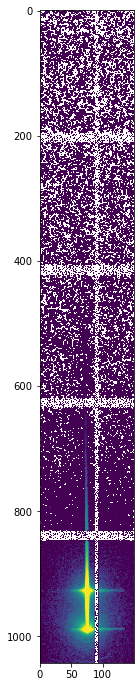

In [45]:
#Define the ROI on the pilatus

#ROI = [x0, y0, size_x, size_y]
#Full image: ROI = [0, 0, 981, 1043]
ROI = [400, 0, 150, 1043]

#Apply the ROI
ROIimages = images[:,ROI[1]:ROI[1]+ROI[3], ROI[0]:ROI[0]+ROI[2]]

fig = plt.figure(figsize=(12,12))
plt.imshow(ROIimages.sum(axis=0), cmap = cmap, vmin = 1,  vmax = 1000, norm=colors.LogNorm())
plt.show()
plt.close()

## Show a single image

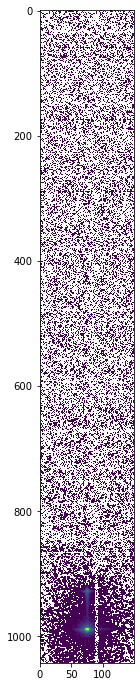

In [46]:
#Show a single image with the ROI
    
#Image number
ind_img = 4

fig = plt.figure(figsize=(12,12))
plt.imshow(ROIimages[ind_img], cmap = cmap, norm=colors.LogNorm())
plt.show()
plt.close()

## Show a 1D scan

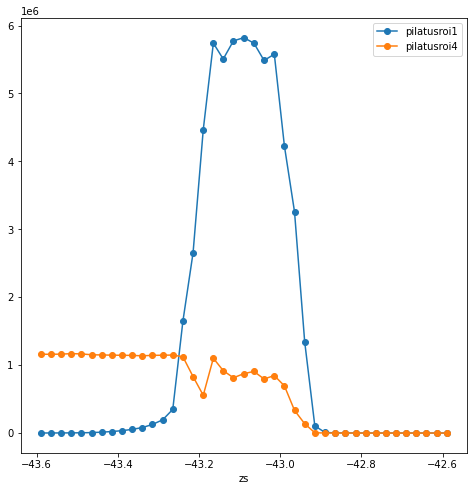

In [47]:
#Choose the sensors and the actuator you want to follow through the scan (must be scalar quantities)
sensors = ['pilatusroi1', 'pilatusroi4']
actuator = 'zs'

#Find the stamps in the Nexus file
stamps = nexus.extractStamps()
i_sensors = np.array([], dtype = 'int')
for i in range(len(stamps)):
    if (stamps[i][1] != None and stamps[i][1].lower() in sensors):
        i_sensors = np.append(i_sensors,i)
    if (stamps[i][1] != None and stamps[i][1].lower() == actuator):
        i_actuator = i

#Extract the values of each elements of the nxs
s, data = nexus.extractData('0D')

fig = plt.figure(figsize=(8,8))
for i_sensor in i_sensors:
    plt.plot(data[i_actuator],data[i_sensor], '-o', label = stamps[i_sensor][1].lower())
    plt.xlabel(actuator)
plt.legend()
plt.show()


## Show a 1D scan with new ROIs for the PILATUS

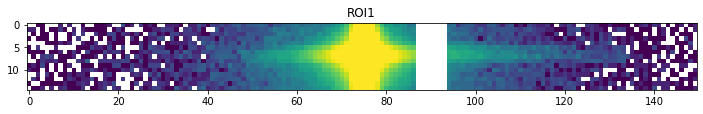

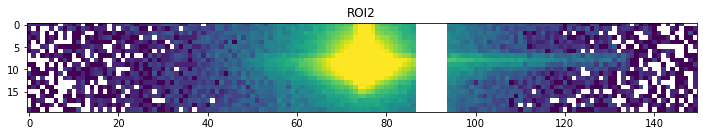

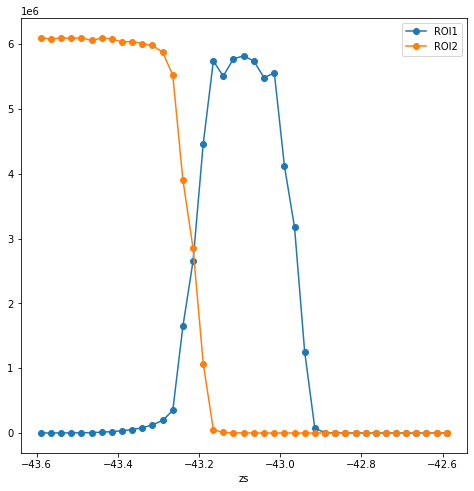

In [48]:
#Define the ROI on the pilatus
#ROI = [x0, y0, size_x, size_y]
#Full image: ROI = [0, 0, 981, 1043]

ROI1 = [400, 920, 150, 15]

#Apply the ROI
ROI1images = images[:,ROI1[1]:ROI1[1]+ROI1[3], ROI1[0]:ROI1[0]+ROI1[2]]

fig = plt.figure(figsize=(12,12))
plt.imshow(ROI1images.sum(axis=0), cmap = cmap,  vmax = 1000, norm=colors.LogNorm())
plt.title('ROI1')
plt.show()
plt.close()

ROI2 = [400, 980, 150, 20]

#Apply the ROI
ROI2images = images[:,ROI2[1]:ROI2[1]+ROI2[3], ROI2[0]:ROI2[0]+ROI2[2]]

fig = plt.figure(figsize=(12,12))
plt.imshow(ROI2images.sum(axis=0), cmap = cmap,  vmax = 1000, norm=colors.LogNorm())
plt.title('ROI2')
plt.show()
plt.close()

#Choose the actuator you want to follow through the scan (must be scalar quantities)
actuator = 'zs'

#Find the stamp of the actuator in the Nexus file
stamps = nexus.extractStamps()
for i in range(len(stamps)):
    if (stamps[i][1] != None and stamps[i][1].lower() == actuator):
        i_actuator = i

#Extract the values of each elements of the nxs
s, data = nexus.extractData('0D')

fig = plt.figure(figsize=(8,8))
plt.plot(data[i_actuator], ROI1images.sum(axis=1).sum(axis=1), '-o', label = 'ROI1')
plt.plot(data[i_actuator], ROI2images.sum(axis=1).sum(axis=1), '-o', label = 'ROI2')
plt.xlabel(actuator)
plt.legend()
plt.show()



# Export

## Export to XXX.dat

Works for any type of scan.  
Convert a scan of N points with M sensors into a txt file of N rows and M columns,  
with at each position NxM the value of the sensor M at the point N of the scan.

In [50]:
#On a single file 

import PyNexus as PN #use version >= 4.1
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

file = "SIRIUS_2019_10_06_00568.nxs"

nexus = PN.PyNexusFile(file, fast=True)

stamps, data = nexus.extractData('0D')
nexus.savePointExtractedData((stamps, data))

zs	m4pitch	delta0	zs	hu36energy	basez	xs	c10tablez_mot	current	dioderefl	mon4i1	mon4i2	mon4i3	mon4i4	pilatusroi1	pilatusroi2	pilatusroi3	pilatusroi4	pilatusroi4max	c10tablepitch	pilatusz1	pilatusz2	mon2i1	mon2i2	mon2i3	mon2i4	integration_time	sensorsRelTimestamps	sensorsTimestamps	i15-c-cx1/ex/v2_grp_zs.pos/pos	



In [56]:
#On all the files of a directory 

from os import listdir
from os.path import isfile, join

path =  "."
files = [f for f in listdir(path) if isfile(join(path, f)) if f.endswith('.nxs')]

for file in files:
    print(file)
    nexus = PN.PyNexusFile(file, fast=True)
    stamps, data = nexus.extractData('0D')
    nexus.savePointExtractedData((stamps, data))

SIRIUS_2019_10_06_00568.nxs
zs	m4pitch	delta0	zs	hu36energy	basez	xs	c10tablez_mot	current	dioderefl	mon4i1	mon4i2	mon4i3	mon4i4	pilatusroi1	pilatusroi2	pilatusroi3	pilatusroi4	pilatusroi4max	c10tablepitch	pilatusz1	pilatusz2	mon2i1	mon2i2	mon2i3	mon2i4	integration_time	sensorsRelTimestamps	sensorsTimestamps	i15-c-cx1/ex/v2_grp_zs.pos/pos	



## Export to XXX_1D.mat and XXX_1D.dat XXX_1D.moy

Made for diffraction scans with Soller slits.  
Defines a ROI around the Soller slits [510, 350, 130, 692].  

XXX_1D.mat:  
For the N images of the scan, sums over the horizontal axis of the ROI image.  
Saves the results as a table of N rows and 692 columns in ascii (.mat).

XXX_1D.mat10, XXX_1D.mat20, XXX_1D.mat40:  
Binning of the images of XXX_1D.mat.  
Saves the results as a table of N rows and int(692//binning) columns in ascii (.mat).  
For example, for binning 10, N rows and 69 columns.

XXX_1D.dat:  
For the N images of the scan, sums over the full ROI, sums over the bottom-half of the ROI, sums over the top-half of the ROI.  
Saves the results as a table of N rows. 1st column is qxy in nm^-1, 2nd column is the full ROI summed, 3rd column is th bottom-half of the ROI summed, 4th column is the top-half of the ROI summed.

XXX_1D.moy10, XXX_1D.moy20, XXX_1D.moy40:
Binning of the matrix (qxy, ROI vertical axis).
Results are saved as 1st column: value of qxy, 2nd column: vertical axis of the ROI, with spacing depending on the value after .moy., 3rd column: ROI summed of XXX_1D.mat summed.

In [58]:
import PyNexus as PN #use version >= 4.1
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

file = "SIRIUS_2019_06_22_01947.nxs"

##################################################
#Import all the full images of the scan first

nexus = PN.PyNexusFile(file, fast=True)

images = extract_images_PILATUS(nexus)
    
#Define the ROI on the pilatus
#ROI = [x0, y0, size_x, size_y]
#Full image: ROI = [0, 0, 981, 1043]

ROI=[510, 350, 130, 692] #Good ROI for Sollers' slits

#Apply the ROI
ROIimages = images[:,ROI[1]:ROI[1]+ROI[3], ROI[0]:ROI[0]+ROI[2]]

There are 301 images in the scan


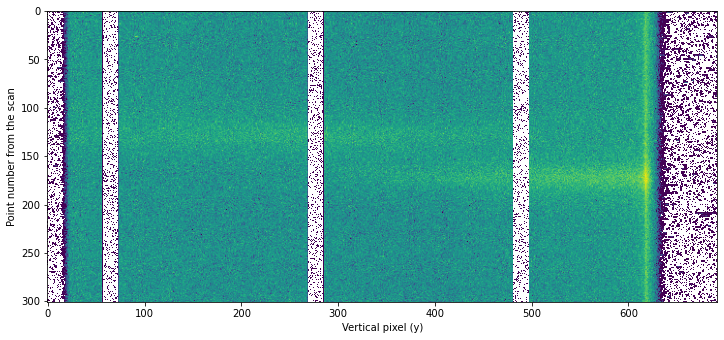

In [59]:
##########################################################################
#Save into XXX_1D.mat

#Sum over the x (horizontal) axis of each image 
ROIimages_sumx = ROIimages.sum(axis=2)

fig = plt.figure(figsize=(12,12))
plt.imshow(ROIimages_sumx, cmap = 'viridis', norm=colors.LogNorm())
plt.xlabel('Vertical pixel (y)')
plt.ylabel('Point number from the scan')
plt.show()
plt.close()

filename_save = file.split('.')[0]
np.savetxt(filename_save+'_1D.mat', ROIimages_sumx)

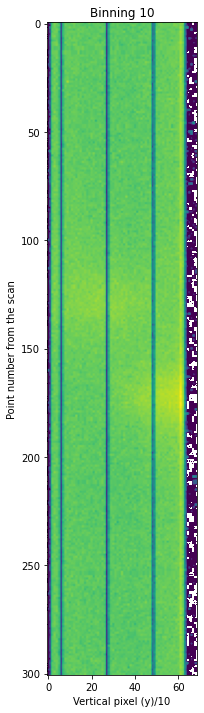

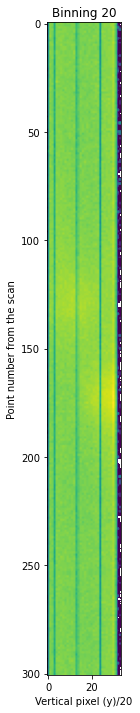

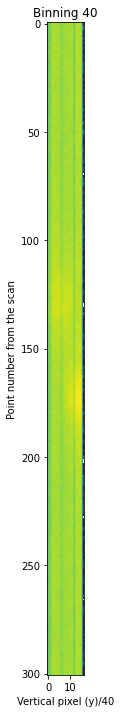

In [60]:
##########################################################################
#Save into XXX_1D.mat10, XXX_1D.mat20, XXX_1D.mat40

binnings = [10, 20, 40]

for binning in binnings:
    ROIimages_sumx_bin = np.zeros((np.shape(ROIimages_sumx)[0],int(np.shape(ROIimages_sumx)[1]//binning)))

    for i in range(np.shape(ROIimages_sumx)[0]):
        for j in range(0, np.shape(ROIimages_sumx)[1]-binning, binning):
            ROIimages_sumx_bin[i,j//binning] = ROIimages_sumx[i,j:j+binning].sum()
            
    fig = plt.figure(figsize=(12,12))
    plt.imshow(ROIimages_sumx_bin, cmap = 'viridis', norm=colors.LogNorm())
    plt.title('Binning %g'%binning)
    plt.xlabel('Vertical pixel (y)/%g'%binning)
    plt.ylabel('Point number from the scan')
    plt.show()

    filename_save = file.split('.')[0]
    np.savetxt(filename_save+'_1D.mat'+str(binning), ROIimages_sumx_bin)     

In [61]:
##########################################################################
#Save into XXX_1D.moy10, XXX_1D.moy20, XXX_1D.moy40

binnings = [10, 20, 40]

#Sum over the x (horizontal) axis of each image 
ROIimages_sumx = ROIimages.sum(axis=2)

#Find the stamp in the Nexus file
stamps = nexus.extractStamps()
for i in range(len(stamps)):
    if (stamps[i][1] != None and stamps[i][1].lower()=='qxy'):
        i_qxy = i

#Extract the values of each elements of the nxs
s, data = nexus.extractData('0D')

for binning in binnings:

    nb_bins =  int(np.shape(ROIimages)[1]//binning)

    ROIimages_moy = np.zeros((np.shape(ROIimages)[0]*nb_bins, 3))

    data_rank = 0
    for i in range(0, np.shape(ROIimages)[0]*nb_bins, nb_bins):
        for j in range(nb_bins):
            ROIimages_moy[i+j, 0] = data[i_qxy][data_rank]
            ROIimages_moy[i+j, 1] = (2*j+1)*binning//2
            ROIimages_moy[i+j, 2] = ROIimages_sumx[data_rank,(2*j)*binning//2:(2*j+2)*binning//2].sum()

        data_rank += 1

    filename_save = file.split('.')[0]
    np.savetxt(filename_save+'_1D.moy'+str(binning), ROIimages_moy)     

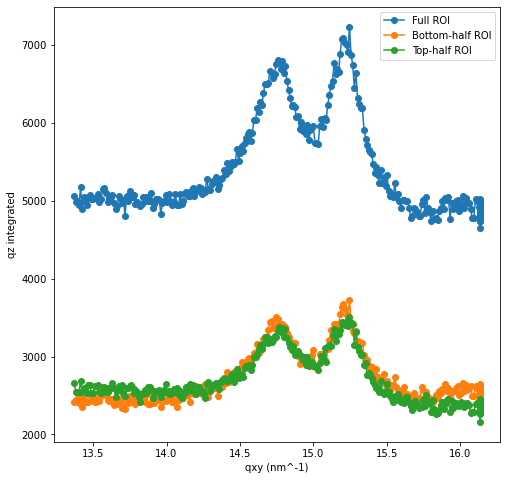

In [62]:
##########################################################################
#Save into XXX_1D.dat

#Find the stamp in the Nexus file
stamps = nexus.extractStamps()
for i in range(len(stamps)):
    if (stamps[i][1] != None and stamps[i][1].lower()=='qxy'):
        i_qxy = i

#Extract the values of each elements of the nxs
s, data = nexus.extractData('0D')

#Sum over the whole ROI for each point of the scan
ROIimages_sum = ROIimages.sum(axis=1).sum(axis=1)

#Sum over the bottom-half of the ROI for each point of the scan
ROIimages_sumbottom = ROIimages[:,:,0:ROI[2]//2].sum(axis=1).sum(axis=1)

#Sum over the top-half of the ROI for each point of the scan
ROIimages_sumtop = ROIimages[:,:,ROI[2]//2:].sum(axis=1).sum(axis=1)

fig = plt.figure(figsize=(8,8))
plt.plot(data[i_qxy], ROIimages_sum, '-o', label = 'Full ROI')
plt.plot(data[i_qxy], ROIimages_sumbottom, '-o', label = 'Bottom-half ROI')
plt.plot(data[i_qxy], ROIimages_sumtop, '-o', label = 'Top-half ROI')
plt.xlabel('qxy (nm^-1)')
plt.ylabel('qz integrated')
plt.legend()
plt.show()

data_to_save = np.array([data[i_qxy], ROIimages_sum, ROIimages_sumbottom, ROIimages_sumtop]).transpose()

filename_save = file.split('.')[0]
np.savetxt(filename_save+'_1D.dat', data_to_save)

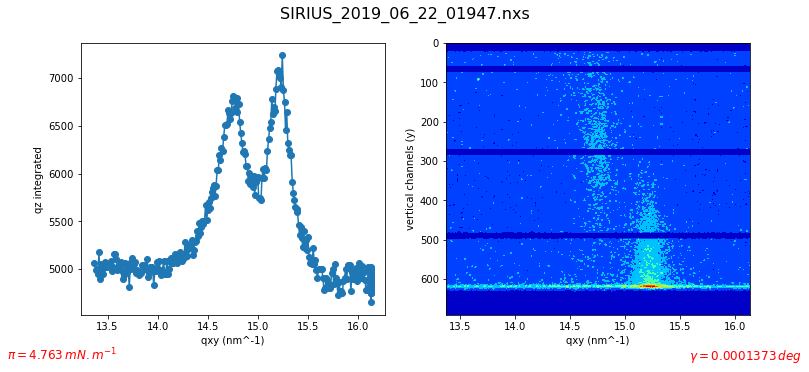

In [63]:
#############################################
#Generate a nice figure for a diffraction scan
#Difference with Philippe's programm : the detector is not flipped here
#(i.e the bottom of the image is the bottom of the detector)

#Sum over the x (horizontal) axis of each image 
ROIimages_sumx = ROIimages.sum(axis=2)

#Find the stamp in the Nexus file
stamps = nexus.extractStamps()
i_pi = None
i_gamma = None
for i in range(len(stamps)):
    if (stamps[i][1] != None and stamps[i][1].lower()=='qxy'):
        i_qxy = i
    if (stamps[i][1] != None and stamps[i][1].lower()=='surfacepressure'):
        i_pi = i
    if (stamps[i][1] != None and stamps[i][1].lower()=='gamma'):
        i_gamma = i

#Extract the values of each elements of the nxs
s, data = nexus.extractData('0D')

#Generate the heatmap image

#The effective size of the sum filter is twice the value of filter_size
filter_size = 1
ROIimages_sumx_filter = np.zeros(np.shape(ROIimages_sumx))

for i in range(np.shape(ROIimages_sumx)[0]):
    for j in range(np.shape(ROIimages_sumx)[1]):
        
        #Exclude the border of the image
        if (j<=filter_size) or (j>=np.shape(ROIimages_sumx)[1]-filter_size+1):
            ROIimages_sumx_filter[i,j] = np.nan
            
        else:
            #Note that we do an average along the vertical axis only
            ROIimages_sumx_filter[i,j] = ROIimages_sumx[i,j-filter_size:j+filter_size].sum() 

            

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)

ax1.plot(data[i_qxy], ROIimages_sum, '-o')
ax1.set_xlabel('qxy (nm^-1)')
ax1.set_ylabel('qz integrated')



ax2 = fig.add_subplot(122)
ax2.contourf(data[i_qxy], np.arange(np.shape(ROIimages_sumx)[1]), ROIimages_sumx_filter.transpose(),
             cmap = 'jet')
ax2.invert_yaxis()
ax2.set_xlabel('qxy (nm^-1)')
ax2.set_ylabel('vertical channels (y)')


fig.suptitle(file.split('\\')[-1], fontsize=16)

if i_pi != None:
    mean_pi = np.mean(data[i_pi])
    fig.text(.04, 0., r'$\pi = %3.4g \, mN.m^{-1}$'%(mean_pi), fontsize='large', color='red')

if i_gamma != None:
    mean_gamma = np.mean(data[i_gamma])
    fig.text(.96, 0., r'$\gamma = %3.4g \,deg$'%(mean_gamma), fontsize='large', color='red', horizontalalignment='right')

plt.show()

# Uncomment to print
#fig.set_size_inches(12,5)
#fig.savefig('.plot.pdf')
#os.startfile(".plot.pdf", "print")

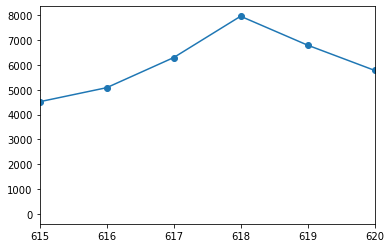

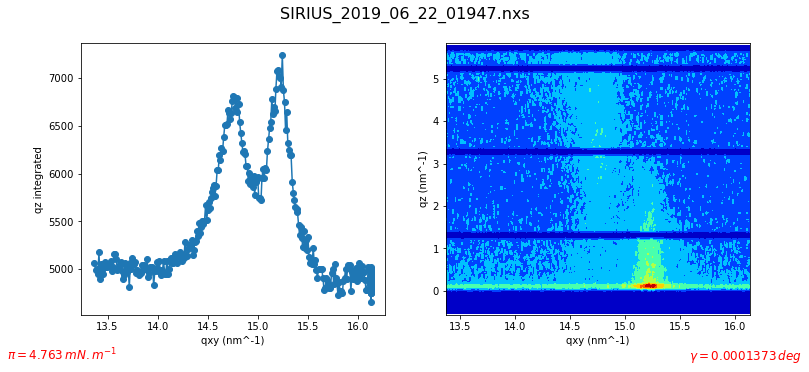

In [64]:
#############################################
# With Qz
# Generate a nice figure for a diffraction scan

# First find the Vineyard's peak

# Integration over qxy (qz, I map)
ROIimages_sum_z = ROIimages.sum(axis=2).sum(axis=0)

fig = plt.figure()

plt.plot(ROIimages_sum_z, '-o')
plt.xlim(615,620)
plt.show()


#Sum over the x (horizontal) axis of each image 
ROIimages_sumx = ROIimages.sum(axis=2)

#Find the stamp in the Nexus file
stamps = nexus.extractStamps()
i_pi = None
i_gamma = None
for i in range(len(stamps)):
    if (stamps[i][1] != None and stamps[i][1].lower()=='qxy'):
        i_qxy = i
    if (stamps[i][1] != None and stamps[i][1].lower()=='surfacepressure'):
        i_pi = i
    if (stamps[i][1] != None and stamps[i][1].lower()=='gamma'):
        i_gamma = i

#Extract the values of each elements of the nxs
s, data = nexus.extractData('0D')

#Generate the heatmap image

#The effective size of the sum filter is twice the value of filter_size
filter_size = 5
ROIimages_sumx_filter = np.zeros(np.shape(ROIimages_sumx))

for i in range(np.shape(ROIimages_sumx)[0]):
    for j in range(np.shape(ROIimages_sumx)[1]):
        
        #Exclude the border of the image
        if (j<=filter_size) or (j>=np.shape(ROIimages_sumx)[1]-filter_size+1):
            ROIimages_sumx_filter[i,j] = np.nan
            
        else:
            #Note that we do an average along the vertical axis only
            ROIimages_sumx_filter[i,j] = ROIimages_sumx[i,j-filter_size:j+filter_size].sum() 

            

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)

ax1.plot(data[i_qxy], ROIimages_sum, '-o')
ax1.set_xlabel('qxy (nm^-1)')
ax1.set_ylabel('qz integrated')


    
#### CONVERSION VERTICAL PIXEL TO QZ ####

# conversion factor alphaf - channel (in deg/chan)
alphaf_factor = 0.013158

# wavelength in nm
llambda = 0.155

# critical angle in rad
alphac = 2.8e-3
    
# channel of Vineyard's peak
channelc = 618

# alphaf in rad
channel = np.arange(np.shape(ROIimages_sumx)[1])

alphaf = alphac + mean_gamma*np.pi/180. + (channelc-channel)*alphaf_factor*np.pi/180.

qz = 2*np.pi/llambda*np.sin(alphaf)

ax2 = fig.add_subplot(122)
ax2.contourf(data[i_qxy], qz, ROIimages_sumx_filter.transpose(),
             cmap = 'jet')
ax2.invert_yaxis()
ax2.set_xlabel('qxy (nm^-1)')
ax2.set_ylabel('qz (nm^-1)')


fig.suptitle(file.split('\\')[-1], fontsize=16)

if i_pi != None:
    mean_pi = np.mean(data[i_pi])
    fig.text(.04, 0., r'$\pi = %3.4g \, mN.m^{-1}$'%(mean_pi), fontsize='large', color='red')

if i_gamma != None:
    mean_gamma = np.mean(data[i_gamma])
    fig.text(.96, 0., r'$\gamma = %3.4g \,deg$'%(mean_gamma), fontsize='large', color='red', horizontalalignment='right')

plt.gca().invert_yaxis()
plt.show()

# Uncomment to print
#fig.set_size_inches(12,5)
#fig.savefig('.plot.pdf')
#os.startfile(".plot.pdf", "print")

SIRIUS_2019_06_22_01947.nxs
There are 301 images in the scan
Saved as SIRIUS_2019_06_22_01947_1D.mat
Saved as SIRIUS_2019_06_22_01947_1D.mat10
Saved as SIRIUS_2019_06_22_01947_1D.mat20
Saved as SIRIUS_2019_06_22_01947_1D.mat40
Saved as SIRIUS_2019_06_22_01947_1D.moy10
Saved as SIRIUS_2019_06_22_01947_1D.moy20
Saved as SIRIUS_2019_06_22_01947_1D.moy40
Saved as SIRIUS_2019_06_22_01947_1D.dat


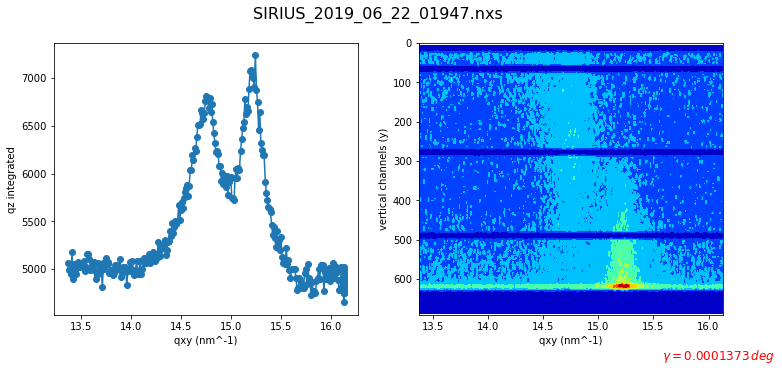

In [65]:
export2_1Dmatdatmoy("SIRIUS_2019_06_22_01947.nxs", isprint = False, issave = True, isprinter = False)

In [66]:
export2_dat("SIRIUS_2019_10_06_00568.nxs")

SIRIUS_2019_10_06_00568.nxs
zs	m4pitch	delta0	zs	hu36energy	basez	xs	c10tablez_mot	current	dioderefl	mon4i1	mon4i2	mon4i3	mon4i4	pilatusroi1	pilatusroi2	pilatusroi3	pilatusroi4	pilatusroi4max	c10tablepitch	pilatusz1	pilatusz2	mon2i1	mon2i2	mon2i3	mon2i4	integration_time	sensorsRelTimestamps	sensorsTimestamps	i15-c-cx1/ex/v2_grp_zs.pos/pos	

Saved as SIRIUS_2019_10_06_00568.dat



# True GIXD data

In [69]:
import PyNexus as PN #use version >= 4.1
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

file = "SIRIUS_2019_06_22_01947.nxs"

##################################################
#Import all the full images of the scan first

nexus = PN.PyNexusFile(file, fast=True)

images = extract_images_PILATUS(nexus)
    
#Define the ROI on the pilatus
#ROI = [x0, y0, size_x, size_y]
#Full image: ROI = [0, 0, 981, 1043]

ROI=[510, 350, 130, 692] #Good ROI for Sollers' slits

#Apply the ROI
ROIimages = images[:,ROI[1]:ROI[1]+ROI[3], ROI[0]:ROI[0]+ROI[2]]

There are 301 images in the scan


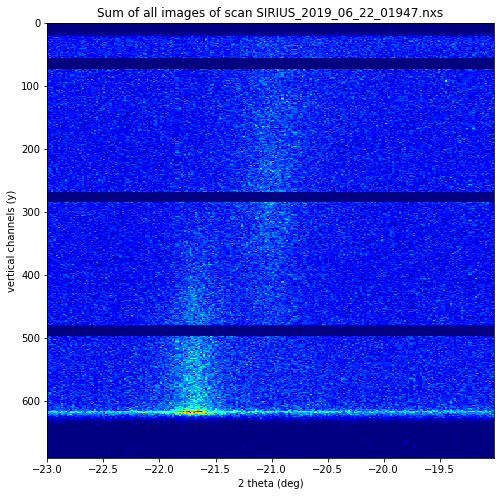

In [77]:
#Extract the values of each elements of the nxs
s, data = nexus.extractData('0D')

#Sum over the whole ROI for each point of the scan
ROIimages_sum = ROIimages.sum(axis=1).sum(axis=1)

#Sum over the x (horizontal) axis of each image 
ROIimages_sumx = ROIimages.sum(axis=2)

#Find the stamp in the Nexus file
stamps = nexus.extractStamps()
i_pi = None
i_gamma = None
for i in range(len(stamps)):
    if (stamps[i][1] != None and stamps[i][1].lower()=='qxy'):
        i_qxy = i
    if (stamps[i][1] != None and stamps[i][1].lower()=='surfacepressure'):
        i_pi = i
    if (stamps[i][1] != None and stamps[i][1].lower()=='gamma'):
        i_gamma = i
    if (stamps[i][1] != None and stamps[i][1].lower()=='delta'):
        i_delta = i


if i_gamma != None:
    mean_gamma = np.mean(data[i_gamma])
    fig.text(.96, 0., r'$\gamma = %3.4g \,deg$'%(mean_gamma), fontsize='large', color='red', horizontalalignment='right')


twotheta = data[i_delta]*np.pi/180.
pixels_y = np.arange(np.shape(ROIimages_sumx)[1])

xx, yy = np.meshgrid(twotheta, pixels_y)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.pcolormesh(xx*180./np.pi, yy, ROIimages_sumx.transpose(), cmap = 'jet')
ax1.invert_yaxis()
ax1.set_title('Sum of all images of scan %s'%file)
ax1.set_xlabel('2 theta (deg)')
ax1.set_ylabel('vertical channels (y)')

plt.show()

## Plot I(2*theta,alphaf)

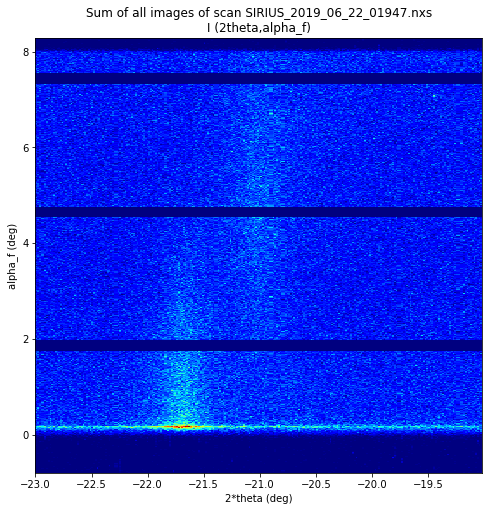

In [78]:
#### CONVERSION VERTICAL PIXEL TO alphaf ####

# conversion factor alphaf - channel (in rad/chan)
alpha_factor = 0.0002296

# critical angle in rad
alphac = 2.8e-3
    
# channel of Vineyard's peak
channelc = 618

# alphaf (exit angle towards the detector)
alphaf = alphac + mean_gamma*np.pi/180. + (channelc-yy)*alpha_factor

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.pcolormesh(twotheta*180./np.pi, alphaf*180./np.pi, ROIimages_sumx.transpose(), cmap = 'jet')
ax1.set_title('Sum of all images of scan %s'%file+'\n'+'I (2theta,alpha_f)')
ax1.set_xlabel('2*theta (deg)')
ax1.set_ylabel('alpha_f (deg)')
plt.show()

## Plot I(qy,qz), I(qxy,qz) and I(qxy,q) 

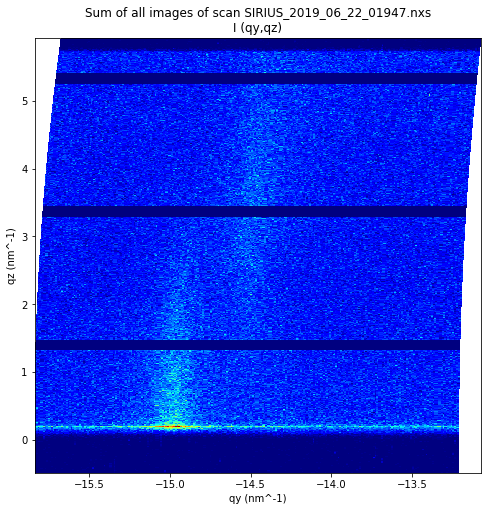

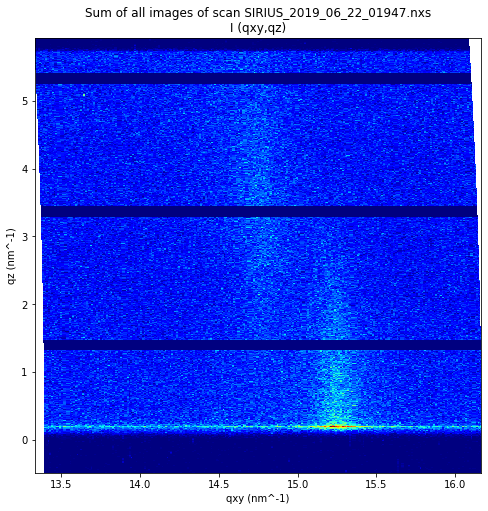

In [79]:
# wavelength in nm
llambda = 0.155

# alphai in rad
alphai = 0.002

# qx, qy, qz in nm^-1
k0 = 2*np.pi/llambda
qx = k0*(np.cos(alphaf)*np.cos(twotheta)-np.cos(alphai))
qy = k0*np.cos(alphaf)*np.sin(twotheta)
qz = k0*(np.sin(alphaf)+np.sin(alphai))
qxy = np.sqrt(np.square(qx)+np.square(qy))
q = np.sqrt(np.square(qxy)+np.square(qz))

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.pcolormesh(qy, qz, ROIimages_sumx.transpose(), cmap = 'jet')
ax1.set_title('Sum of all images of scan %s'%file+'\n'+'I (qy,qz)')
ax1.set_xlabel('qy (nm^-1)')
ax1.set_ylabel('qz (nm^-1)')
plt.show()

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.pcolormesh(qxy, qz, ROIimages_sumx.transpose(), cmap = 'jet')
ax1.set_title('Sum of all images of scan %s'%file+'\n'+'I (qxy,qz)')
ax1.set_xlabel('qxy (nm^-1)')
ax1.set_ylabel('qz (nm^-1)')
plt.show()

# Nice plots and fit

In [80]:
import numpy as np
import pylab as P
from scipy.optimize import curve_fit
pi = np.pi

import pandas as pd
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import cm


#Functions used for fitting the peaks

def lorentz(x, A, x1, w):
    #Single Lorentz peak without background
    return A/(1+np.power((x-x1)/w, 2.0))

def lorentz1(x, A0, B0, A1, x1, w1 ): 
    #One Lorentz peak + bckg
    result = A0*x + B0
    result += lorentz(x, A1, x1, w1)
    return result

def lorentz2(x, A0, B0, A1, x1, w1, A2, x2, w2):
    #Two Lorentz peaks + bckg
    result = A0*x + B0
    result += lorentz(x, A1, x1, w1)
    result += lorentz(x, A2, x2, w2)
    return result

def sinc(x, B, C, x0, L):
    result = (x-x0)*L/2.
    result = B + C*np.power(np.sin(result)/result, 2.0)
    return result

def sinc0(x, B, C, L):
    result = x*L/2.
    result = B + C*np.power(np.sin(result)/result, 2.0)
    return result

def peaks_sinc0(x, B0, C0, L0, B1, C1, x1, L1):
    #A sum of sinc0 and sinc
    return sinc0(x, B0, C0, L0)+sinc(x, B1, C1, x1, L1)

def peaks_sinc(x, B0, C0, x0, L0, B1, C1, x1, L1):
    #A sum of sinc and sinc
    return sinc(x, B0, C0, x0, L0)+sinc(x, B1, C1, x1, L1)


def groupe(bin, mat):
    #Rearrange and bin matrix
    tmp=[]
    for i in range(mat.shape[0]):
        x=[]
        y=[]
        z=[]
        j=0
        while j+bin<mat.shape[1]:
            y.append(j+float(bin)/2.0)
            z.append(mat[i, j:j+bin].sum())
            j=j+bin
        tmp.append(z)
    return (np.array(y), np.array(tmp)) 

## Gamma = 0

In [83]:
# Use .dat and .mat
filename = 'SIRIUS_2019_04_05_00863'

#Angle out-of-plane of the detector (in degrees)
gamma = 0.

#General parameters for plots
#P.rc('text', usetex=False)
#P.rc('font', family='serif')
fontsize = 20
labelsize = 17
P.rc('axes', linewidth=1)

### Conversion from channel to qz

#### Find the position of the Vineyard peak (if gamma = 0 only)

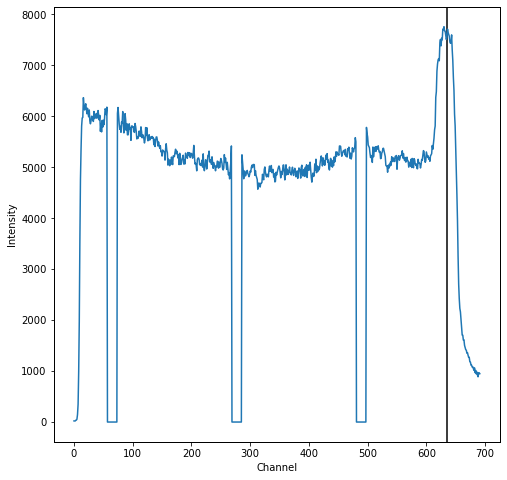

In [84]:
#Move the vertical line to find the Vineyard peak
chan0 = 635

#Import the matrix (qxy, channel, intensity)
mat0 = P.loadtxt(filename+'_1D.mat')


#Integrate along qxy
Iqxy = mat0.sum(axis=0)

fig = P.figure(1,figsize=(8, 8))
P.ylabel("Intensity")
P.xlabel("Channel")
P.axvline(x=chan0, color = 'black')
P.plot(Iqxy)
P.show()

#### Convert channels to qz

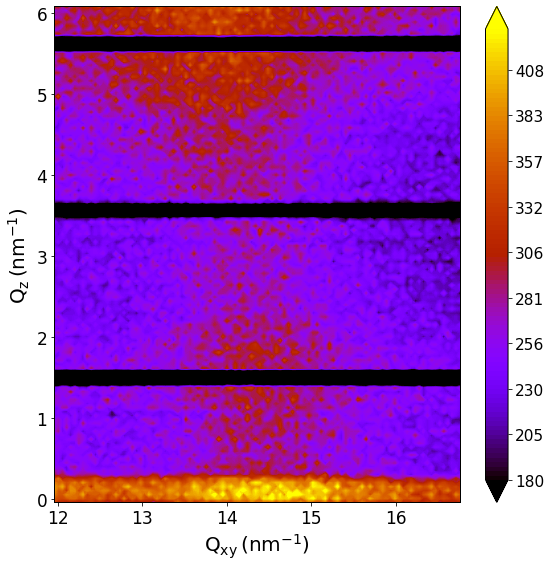

In [86]:
#Use the calibration from the lab book (degrees per channel)
calib = 0.013786
#Critical angle of total reflection (in degrees)
thetac = 0.12
#Wavelength (in nm)
llambda = 0.155


#Extract the qxy
data = P.loadtxt(filename+'_1D.dat')
start = 0
stop = data.shape[0]
qxy = data[start:stop,0]


#Bin the data
chan, mat = groupe(5, mat0)
mat = mat.transpose()

thetaz = (chan0-chan)*calib*pi/180.0 + (thetac*pi/180.0) + gamma*pi/180.
qz = 2.*pi*np.sin(thetaz)/llambda


fig = P.figure(1,figsize=(8, 8))
ax1 = fig.add_subplot(111)
lev = np.linspace(180, mat.max()*0.95, 100)

ax1.set_ylabel(r'$\rm Q_z \,(nm^{-1})$', fontsize=fontsize)
ax1.set_xlabel(r'$\rm Q_{xy} \,(nm^{-1})$', fontsize=fontsize)
ax1.tick_params(axis='both', labelsize=labelsize)

cs = ax1.contourf(qxy, qz[3:-8], mat[3:-8,:], levels=lev, cmap = cm.gnuplot, extend = "both")
cb = P.colorbar(cs, format = "%d")
cb.ax.tick_params(labelsize = labelsize*0.9) 


fig.tight_layout()
P.savefig('2D_Gamma0.png', dpi=300)

### I vs Qxy + fit of the peaks

Rod positions: 
Rod A qxy (nm-1) =  13.9983 std =  0.185293
Rod A L (nm-1) =  0.785433 std =  0.320463
Rod B qxy (nm-1) = : 14.6066 std =  0.531303
Rod B L (nm-1) =  1.14245 std =  0.242654



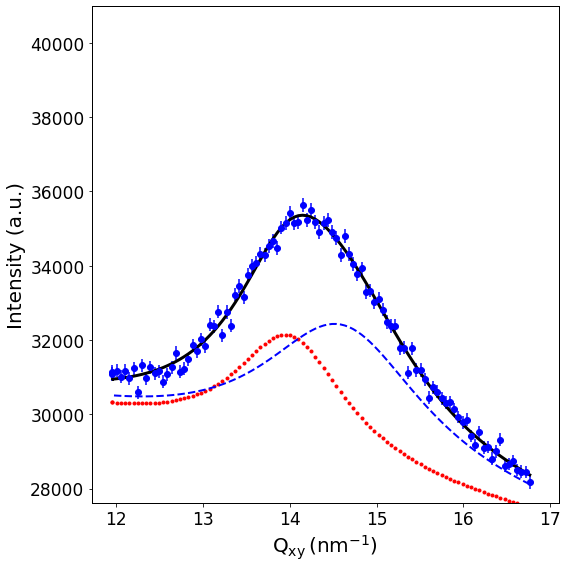

In [88]:
fig = P.figure(1,figsize=(8, 8))

ax2 = fig.add_subplot(111)


# Figure A
# Integrated over Qz

#Extract the intensity
y = data[start:stop,1]
err = np.sqrt(y)

ax2.set_ylabel(r'Intensity (a.u.)', fontsize=fontsize)
ax2.set_xlabel(r'$\rm Q_{xy} \,(nm^{-1})$', fontsize=fontsize)
ax2.tick_params(axis='both', labelsize=labelsize)
ax2.axis((qxy.min()*.98, qxy.max()*1.02, y.min()*.98, y.max()*1.15))
ax2.errorbar(qxy, y, yerr=err, fmt='bo')

#Fit

#Fit params: A0, B0, A1, x1, w1, A2, x2, w2
#Initial guess
p0 = (-1., 15000,  30000., 13.7, .08, 30000, 14.8, .1 )

#Fit with two peaks
result, pcov = curve_fit(lorentz2, qxy, y , p0=p0)
peaks = result
error = np.sqrt(np.diag(pcov))

yfit = lorentz2(qxy, result[0], result[1], result[2], result[3], result[4], 
        result[5], result[6], result[7])
ax2.plot(qxy, yfit, 'k-', lw=3)

#First peak only
yfit1 = lorentz1(qxy, result[0], result[1], result[2], result[3], result[4])
ax2.plot(qxy, yfit1, 'r.', lw=2)

#Second peak only
yfit2 = lorentz1(qxy, result[0],  result[1], result[5], result[6], result[7])
ax2.plot(qxy, yfit2, 'b--', lw=2)


print('Rod positions: ')
print('Rod A qxy (nm-1) = ', '{:g}'.format(result[3]), 'std = ', '{:g}'.format(error[3]))
print('Rod A L (nm-1) = ', '{:g}'.format(result[4]), 'std = ', '{:g}'.format(error[4]))

print('Rod B qxy (nm-1) = :', '{:g}'.format(result[6]), 'std = ', '{:g}'.format(error[6]))
print('Rod B L (nm-1) = ', '{:g}'.format(result[7]), 'std = ', '{:g}'.format(error[7]))
print()

fig.tight_layout()
P.savefig('qxy_Gamma0.png', dpi=300)

### Analyze I vs qz (Bragg's rods)

#### Rod A

Rod A qxy (nm-1): 13.9983
ROI peak: 13.6147 14.392

Peak qz:
qz (nm-1): 6.02371 , std: 0.273028
Lz (nm): 2.69473 , std: 0.674659


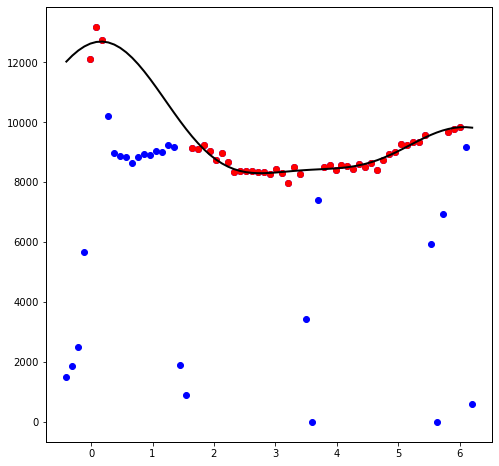

In [89]:
#Bin the data
chan, mat = groupe(10, mat0)

thetaz = (chan0-chan)*calib*pi/180.0 + (thetac*pi/180.0) + gamma*pi/180.
qz = 2.*pi*np.sin(thetaz)/llambda

#############
#Rod A
#############

#Focus the analyze on one peak
sort = qxy.sort()
qpeak = peaks[3]
i1=qxy.searchsorted(qpeak-peaks[4]/2.0, sorter=sort)
i2=qxy.searchsorted(qpeak+peaks[4]/2.0, sorter=sort)


#Integration of the peak along qxy (rod)
rod = mat[i1:i2,:].sum(axis=0)

#Remove manually the dead zones of the detector for the fit
#From high qz to low qz
min0 = 2
max0 = 5

min1 = 8
max1 = 26

min2 = 29
max2 = 48

min3 = 62
max3 = 65

newqz=np.concatenate((qz[min0:max0], qz[min1:max1], qz[min2:max2], qz[min3:max3]))
newrod=np.concatenate((rod[min0:max0], rod[min1:max1], rod[min2:max2], rod[min3:max3]))

fig = P.figure(1,figsize=(8, 8))

ax3 = fig.add_subplot(111)

ax3.plot(qz, rod,'bo')
ax3.plot(newqz, newrod, 'ro')

#Fit

#Params sinc0 B, C, L
#Params sinc  B, C, x0, L
#Params peaks_sinc B0, C0, x0, L0, B1, C1, x1, L1

p0=(1000, 6000., 0.1, 2.0, 1000, 6000., 6, 2.0)

result, pcov =curve_fit(peaks_sinc, newqz, newrod , p0=p0)
yfit=peaks_sinc(qz, result[0],  result[1], result[2], result[3], 
                result[4],  result[5], result[6], result[7]) 
ax3.plot(qz, yfit,'k-', lw=2)

error = np.sqrt(np.diag(pcov))

print('Rod A qxy (nm-1):', '{:g}'.format(qpeak))
print('ROI peak:', '{:g}'.format(qxy[i1]), '{:g}'.format(qxy[i2]))
print('')

print('Peak qz:')
#print('qz (nm-1):', result[2], ', std:', error[2])
#print('L (nm):', result[3], ', std:', error[3])
#print(' ')
print('qz (nm-1):', '{:g}'.format(result[6]), ', std:', '{:g}'.format(error[6]))
print('Lz (nm):', '{:g}'.format(result[7]), ', std:', '{:g}'.format(error[7]))

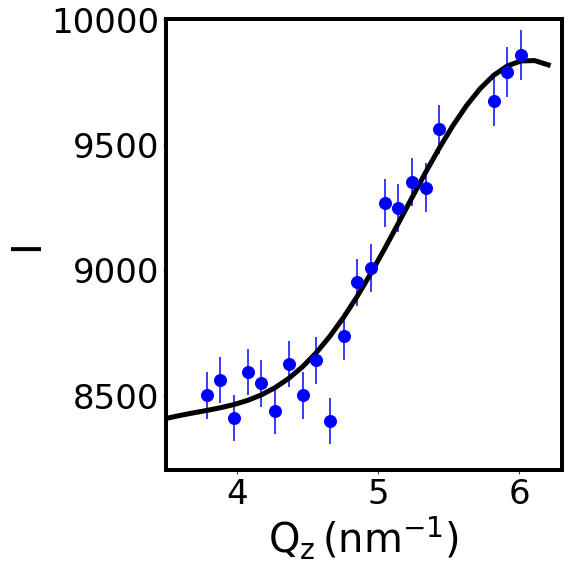

In [91]:
fig = P.figure(1,figsize=(8, 8))
P.rc('axes', linewidth=4)

ax3b = fig.add_subplot(111)

ax3b.set_ylabel(r'I', fontsize=fontsize*2)
ax3b.set_xlabel(r'$\rm Q_{z} \,(nm^{-1})$', fontsize=fontsize*2)
ax3b.tick_params(axis='both', labelsize=labelsize*2)
ax3b.plot(qz, yfit,'k-', lw=5)
ax3b.axis((3.5, 6.3, 8200, 10000))

err = np.sqrt(newrod)

ax3b.errorbar(newqz, newrod, yerr=err, fmt='bo', markersize=12)

fig.tight_layout()
P.savefig('qz_Gamma0.png', dpi=300, transparent=True)

P.rc('axes', linewidth=1)

#### Rod B

Rod B qxy (nm-1): 14.606624130764885
ROI peak: 14.052509779370201 15.216913271016534

Peak qz:
qz (nm-1): 0.192912 , std: 0.175399
Lz (nm): 2.63693 , std: 0.288632



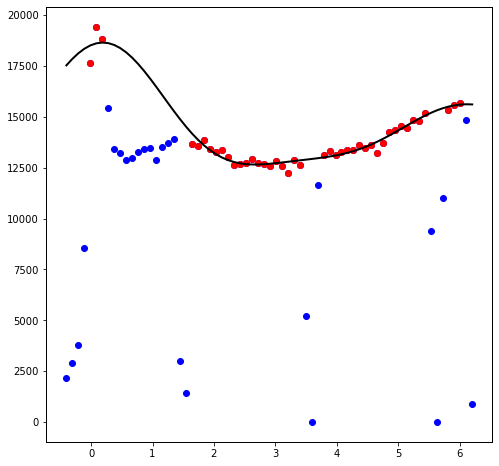

In [92]:
#Bin the data
chan, mat = groupe(10, mat0)

thetaz = (chan0-chan)*calib*pi/180.0 + (thetac*pi/180.0) + gamma*pi/180.
qz = 2.*pi*np.sin(thetaz)/llambda


#############
#Peak B
#############

#Focus the analyze on one peak
sort = qxy.sort()
qpeak = peaks[6]
i1=qxy.searchsorted(qpeak-peaks[7]/2.0, sorter=sort)
i2=qxy.searchsorted(qpeak+peaks[7]/2.0, sorter=sort)


#Integration of the peak along qxy (rod)
rod = mat[i1:i2,:].sum(axis=0)

#Remove manually the dead zones of the detector for the fit
#From high qz to low qz
min0 = 2
max0 = 5

min1 = 8
max1 = 26

min2 = 29
max2 = 48

min3 = 62
max3 = 65

newqz=np.concatenate((qz[min0:max0], qz[min1:max1], qz[min2:max2], qz[min3:max3]))
newrod=np.concatenate((rod[min0:max0], rod[min1:max1], rod[min2:max2], rod[min3:max3]))

fig = P.figure(1,figsize=(8, 8))

ax4 = fig.add_subplot(111)

ax4.plot(qz, rod,'bo')
ax4.plot(newqz, newrod, 'ro')

#Fit

#Params sinc0 B, C, L
#Params sinc  B, C, x0, L
#Params peaks_sinc B0, C0, x0, L0, B1, C1, x1, L1

p0=(1000, 6000., 0.1, 2.0, 1000, 6000., 6, 2.0)

result, pcov =curve_fit(peaks_sinc, newqz, newrod , p0=p0)
yfit=peaks_sinc(qz, result[0],  result[1], result[2], result[3],
                result[4],  result[5], result[6], result[7]) 
ax4.plot(qz, yfit,'k-', lw=2)

error = np.sqrt(np.diag(pcov))

print('Rod B qxy (nm-1):', qpeak)
print('ROI peak:', qxy[i1], qxy[i2])
print('')

print('Peak qz:')
print('qz (nm-1):',  '{:g}'.format(result[2]), ', std:', '{:g}'.format(error[2]))
print('Lz (nm):', '{:g}'.format(result[3]), ', std:', '{:g}'.format(error[3]))
print()



## Gamma = 4

In [94]:
# Use .dat and .mat
filename = 'SIRIUS_2019_04_05_00864'

#Angle out-of-plane of the detector (in degrees)
gamma = 4.

#General parameters for plots
#P.rc('text', usetex=False)
#P.rc('font', family='serif')
fontsize = 17
labelsize = 15

### Conversion from channel to qz

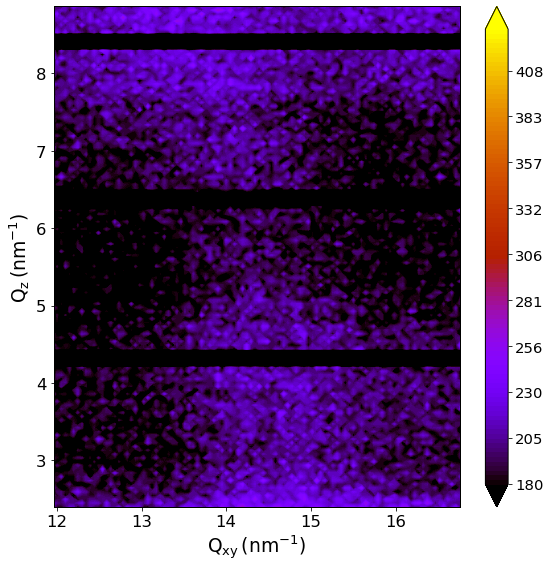

In [98]:
#Use the calibration from the lab book (degrees per channel)
calib = 0.013786
#Critical angle of total reflection (in degrees)
thetac = 0.12
#Wavelength (in nm)
llambda = 0.155

#Extract the qxy
data = P.loadtxt(filename+'_1D.dat')
start = 0
stop = data.shape[0]
qxy = data[start:stop,0]

#Import the matrix (qxy, channel, intensity)
mat0 = P.loadtxt(filename+'_1D.mat')

#Bin the data
chan, mat = groupe(5, mat0)
mat = mat.transpose()


thetaz = (chan0-chan)*calib*pi/180.0 + (thetac*pi/180.0) + gamma*pi/180.
qz = 2.*pi*np.sin(thetaz)/llambda


fig = P.figure(1,figsize=(8, 8))
ax5 = fig.add_subplot(111)
#lev = np.linspace(160, int(mat.max()*1), 100)

lev = np.linspace(180, 431.29999999999995, 100)

ax5.set_ylabel(r'$\rm Q_z \,(nm^{-1})$', fontsize=fontsize*1.1)
ax5.set_xlabel(r'$\rm Q_{xy} \,(nm^{-1})$', fontsize=fontsize*1.1)
ax5.tick_params(axis='both', labelsize=labelsize*1.1)

cs = ax5.contourf(qxy, qz[3:], mat[3:,:], levels=lev, cmap = cm.gnuplot, extend = "both")
cb = P.colorbar(cs, format = "%d")
cb.ax.tick_params(labelsize = labelsize*0.9*1.1) 


fig.tight_layout()
P.savefig('2D_Gamma4.png', dpi=300)

### I vs Qxy + fit of the peaks

Rod positions: 
Rod C qxy (nm-1) =  14.108418452519185 std =  0.05864275620913327
Rod C L (nm-1) =  0.7027933893666148 std =  0.08606265661712444
Traces of Rod B qxy (nm-1) = : 14.94961497297596 std =  0.08266816236810706



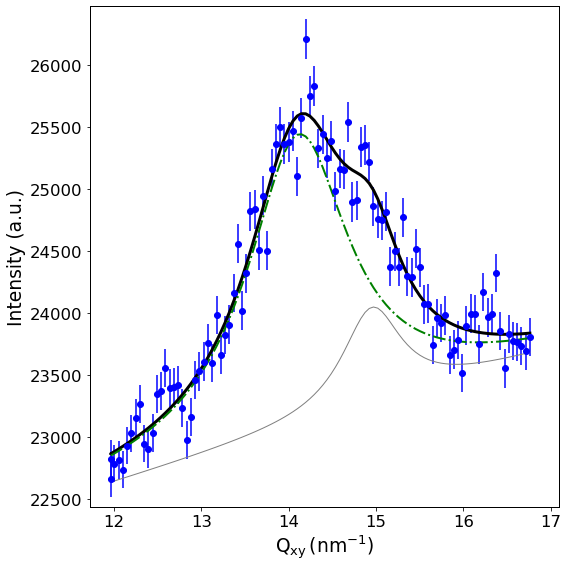

In [99]:
fig = P.figure(1,figsize=(8, 8))

ax6 = fig.add_subplot(111)


# Figure A
# Integrated over Qz

data = P.loadtxt(filename+'_1D.dat')

start = 0
stop = data.shape[0]
y = data[start:stop,1]
qxy = data[start:stop,0]
err = np.sqrt(y)

ax6.set_ylabel(r'Intensity (a.u.)', fontsize=fontsize*1.1)
ax6.set_xlabel(r'$\rm Q_{xy} \,(nm^{-1})$', fontsize=fontsize*1.1)
ax6.tick_params(axis='both', labelsize=labelsize*1.1)
ax6.axis((qxy.min()*.98, qxy.max()*1.02, y.min()*.99, y.max()*1.01))
ax6.errorbar(qxy, y, yerr=err, fmt='bo')

#Fit

#Fit params: A0, B0, A1, x1, w1, A2, x2, w2
#Initial guess
p0 = (-1., 15000,  30000., 13.7, .08, 30000, 14.6, .1 )

#Fit with two peaks


result, pcov = curve_fit(lorentz2, qxy, y , p0=p0)
peaks = result
error = np.sqrt(np.diag(pcov))

yfit = lorentz2(qxy, result[0], result[1], result[2], result[3], result[4], 
        result[5], result[6], result[7])
ax6.plot(qxy, yfit, 'k-', lw=3)

#First peak only
yfit1 = lorentz1(qxy, result[0], result[1], result[2], result[3], result[4])
ax6.plot(qxy, yfit1, 'g-.', lw=2)

#Second peak only
yfit2 = lorentz1(qxy, result[0],  result[1], result[5], result[6], result[7])
ax6.plot(qxy, yfit2, color = 'gray', linestyle = '-', lw=1)


print('Rod positions: ')
print('Rod C qxy (nm-1) = ', result[3], 'std = ', error[3])
print('Rod C L (nm-1) = ', result[4], 'std = ', error[4])
print('Traces of Rod B qxy (nm-1) = :', result[6], 'std = ', error[6])
print()


fig.tight_layout()
P.savefig('qxy_Gamma4.png', dpi=300)

### Analyze I vs qz (Bragg's rods)

ROI peak: 13.80556327536074 14.486144929020087
Rod C qxy (nm-1): 14.108418452519185
ROI peak: 13.80556327536074 14.486144929020087

Peak qz:
qz (nm-1): 9.39017905891094 , std: 1.6138824023959288
L (nm): 2.195906005423756 , std: 1.7043230831521736



/Users/arnaudhemmerle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in sqrt


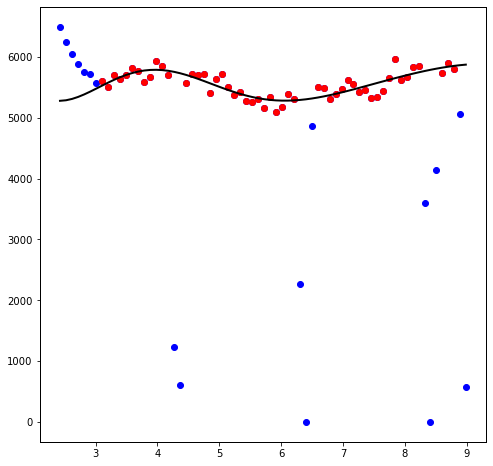

In [100]:
#Bin the data
chan, mat = groupe(10, mat0)

thetaz = (chan0-chan)*calib*pi/180.0 + (thetac*pi/180.0) + gamma*pi/180.
qz = 2.*pi*np.sin(thetaz)/llambda

#############
#Peak C
#############

#Focus the analyze on one peak
sort = qxy.sort()
qpeak = peaks[3]
i1=qxy.searchsorted(qpeak-peaks[4]/2.0, sorter=sort)
i2=qxy.searchsorted(qpeak+peaks[4]/2.0, sorter=sort)
print('ROI peak:', qxy[i1], qxy[i2])


#Integration of the peak along qxy (rod)
rod = mat[i1:i2,:].sum(axis=0)

#Remove manually the dead zones of the detector for the fit
#From high qz to low qz
min0 = 2
max0 = 5

min1 = 8
max1 = 26

min2 = 29
max2 = 48

min3 = 50
max3 = 62

newqz=np.concatenate((qz[min0:max0], qz[min1:max1], qz[min2:max2], qz[min3:max3]))
newrod=np.concatenate((rod[min0:max0], rod[min1:max1], rod[min2:max2], rod[min3:max3]))

fig = P.figure(1,figsize=(8, 8))

ax7 = fig.add_subplot(111)

ax7.plot(qz, rod,'bo')
ax7.plot(newqz, newrod, 'ro')

#Fit

#Params sinc0 B, C, L
#Params sinc  B, C, x0, L
#Params peaks0 B0, C0, L0, B1, C1, x1, L1
#Params peaks B0, C0, L0, x0, B1, C1, x1, L1

p0=(1000, 6000., 2., 4., 1000, 6000., 8.5, 2.0)

result, pcov =curve_fit(peaks_sinc, newqz, newrod , p0=p0)
yfit=peaks_sinc(qz, result[0],  result[1], result[2], result[3],
                result[4],  result[5], result[6], result[7]) 
ax7.plot(qz, yfit,'k-', lw=2)

error = np.sqrt(np.diag(pcov))

print('Rod C qxy (nm-1):', qpeak)
print('ROI peak:', qxy[i1], qxy[i2])
print('')

print('Peak qz:')
print('qz (nm-1):', result[6], ', std:', error[6])
print('L (nm):', result[7], ', std:', error[7])
print()

# Fit the structure

In [101]:
from lmfit import Minimizer, Parameters, report_fit
import itertools

def f_qxy11(a, b, gamma):
    return 2*pi*np.sqrt(a**2+b**2-2*a*b*np.cos(gamma))/(a*b*np.sin(gamma))

def f_qxy1bar1(a, b, gamma):
    return 2*pi*np.sqrt(a**2+b**2+2*a*b*np.cos(gamma))/(a*b*np.sin(gamma))
    
def f_qxy02(a, b, gamma):
    return 4*pi/(b*np.sin(gamma))

def f_qz11(a , b, gamma, psi, theta):
    return -2*pi*np.tan(theta)/(a*b*np.sin(gamma))*(b*np.sin(gamma)*np.cos(psi)-(b*np.cos(gamma)-a)*np.sin(psi))

def f_qz1bar1(a , b, gamma, psi, theta):
    return -2*pi*np.tan(theta)/(a*b*np.sin(gamma))*(b*np.sin(gamma)*np.cos(psi)-(b*np.cos(gamma)+a)*np.sin(psi))

def f_qz02(a , b, gamma, psi, theta):
    return -4*pi/(b*np.sin(gamma))*np.tan(theta)*np.sin(psi)

def f_chi2(params, *qexp):
    
    a = params['a']
    b = params['b']
    gamma = params['gamma']
    psi = params['psi']
    theta = params['theta']
    
    qth = np.array([
           (f_qxy11(a, b, gamma), f_qz11(a , b, gamma, psi, theta)),
           (f_qxy1bar1(a, b, gamma), f_qz1bar1(a , b, gamma, psi, theta)),
           (f_qxy02(a, b, gamma), f_qz02(a , b, gamma, psi, theta))
          ])
    
    return np.sum(np.square(qth-qexp))

In [102]:
#Put here the q vectors

qxyA = 1.52
qzA = 0.

qxyB = 1.52
qzB = 0.

qxyC = 1.48
qzC = 0.4

qexp = np.array([(qxyA, qzA), (qxyB, qzB), (qxyC, qzC)])

print('### EXPERIMENTAL RESULTS ###')
print('qxyA (nm-1) = {:.4f}, qzA (nm-1) = {:.4f}'.format(qexp[0,0],qexp[0,1]))
print('qxyB (nm-1) = {:.4f}, qzB (nm-1) = {:.4f}'.format(qexp[1,0],qexp[1,1]))
print('qxyC (nm-1) = {:.4f}, qzC (nm-1) = {:.4f}'.format(qexp[2,0],qexp[2,1]))

params = Parameters()

params.add('a', value=0.5)
params.add('b', value=0.7)
params.add('gamma', value=pi/4)
params.add('psi', value=0.1)
params.add('theta', value=-.2)


#We look at the chi2 of all the permutation of the q vectors
#To find the right ordering of peaks
qexp_permut = np.array(list(itertools.permutations(qexp)))
chi2 = np.array(6*[0.])
result = {}

for i in range(6):
        minner = Minimizer(f_chi2, params, fcn_args=qexp_permut[i])
        result[i] = minner.minimize(method = 'BFGS')
        chi2[i] = result[i].chisqr
        
imin = np.argmin(chi2)

resultf = result[imin]

a = resultf.params['a'].value
b = resultf.params['b'].value
gamma = resultf.params['gamma'].value
psi = resultf.params['psi'].value
theta = resultf.params['theta'].value

print("")
print('### BEST FIT ###')
print('### In rectangular structure ###')
print('ar (nm) = ', '{:.4f}'.format(a))
print('br (nm) = ', '{:.4f}'.format(b))
print('gammar (deg) = ', '{:.2f}'.format(gamma*180./pi))
print('psi (deg) = ', '{:.2f}'.format(psi*180./pi))
print('theta (deg) = ', '{:.2f}'.format(theta*180./pi))


qth_best = np.array([
       (f_qxy11(a, b, gamma), f_qz11(a , b, gamma, psi, theta)),
       (f_qxy1bar1(a, b, gamma), f_qz1bar1(a , b, gamma, psi, theta)),
       (f_qxy02(a, b, gamma), f_qz02(a , b, gamma, psi, theta))
      ])

print('qxy11 (nm-1) = {:.4f}, qz11 (nm-1) = {:.4f}'.format(qth_best[0,0],qth_best[0,1]))
print('qxy1bar1 (nm-1) = {:.4f}, qz1bar1 (nm-1) = {:.4f}'.format(qth_best[1,0],qth_best[1,1]))
print('qxy02 (nm-1) = {:.4f}, qz02 (nm-1) = {:.4f}'.format(qth_best[2,0],qth_best[2,1]))


### EXPERIMENTAL RESULTS ###
qxyA (nm-1) = 1.5200, qzA (nm-1) = 0.0000
qxyB (nm-1) = 1.5200, qzB (nm-1) = 0.0000
qxyC (nm-1) = 1.4800, qzC (nm-1) = 0.4000

### BEST FIT ###
### In rectangular structure ###
ar (nm) =  4.8603
br (nm) =  8.2712
gammar (deg) =  -628.25
psi (deg) =  -29.13
theta (deg) =  169.79
qxy11 (nm-1) = 1.5200, qz11 (nm-1) = 0.1333
qxy1bar1 (nm-1) = 1.4800, qz1bar1 (nm-1) = 0.2667
qxy02 (nm-1) = 1.5200, qz02 (nm-1) = -0.1333


<a id='Recover'></a>
# Recover the real space structure

## Rectangular structure

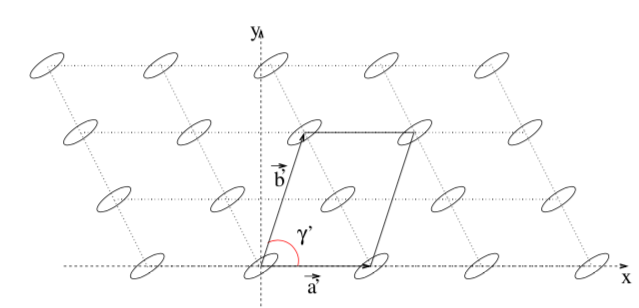

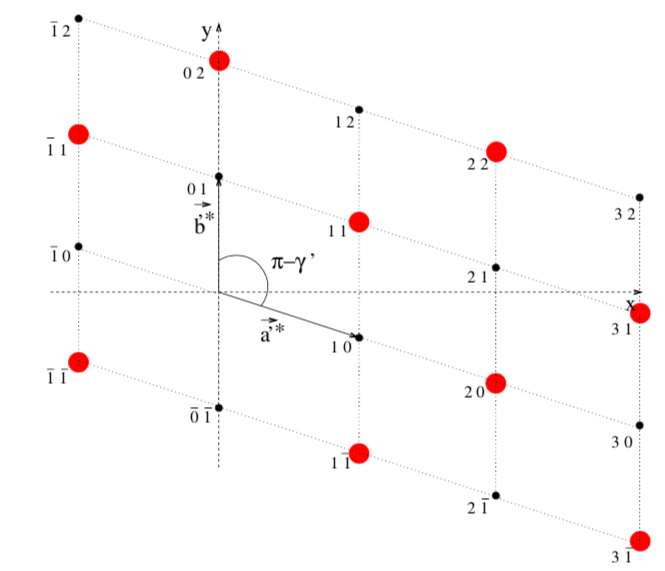

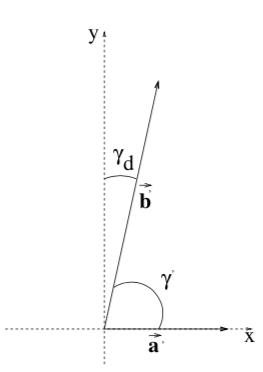

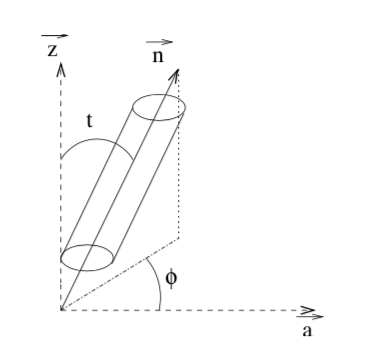

In [108]:
#Using Phillipe's notations
#Direct space
display(Image(filename='../GIXD_images/Definitions_PF_direct_rect.png', width = 500))

#Reciprocal space
display(Image(filename='../GIXD_images/Definitions_PF_recip_rect.png', width = 400))

#Other convention for distortion
display(Image(filename='../GIXD_images/Definitions_PF_angles_distortion.png', width = 200))

#Tilt and azimuth
display(Image(filename='../GIXD_images/Definitions_PF_angles_tilt.png', width = 400))

In [105]:
#With rectangular peaks indices

#PEAK 11
qxy11r = 15.2
std_qxy11r = 0.18529

lxy11r = 0.7854
std_lxy11r = 0.32046

qz11r = 1e-5
std_qz11r = 0.273028

lz11r = 2.69473
std_lz11r = 0.674659

#DEGENERATED PEAK 1bar1
qxy1bar1r = qxy11r
std_qxy1bar1r = std_qxy11r

lxy1bar1r = lxy11r
std_lxy1bar1r = std_lxy11r

qz1bar1r = qz11r
std_qz1bar1r = std_qz11r

lz1bar1r = lz11r
std_lz1bar1r = std_lz11r

#PEAK 02
qxy02r = 14.8
std_qxy02r = 0.5313

lxy02r = 1.14245
std_lxy02r = 0.24265

#qz02r = 1e-5 #Forced to be at zero
qz02r = 3.5
std_qz02r = 0.2

lz02r = 2.63693
std_lz02r = 0.288632




from uncertainties import ufloat
import uncertainties.umath as umath

#Put the peak position and its std

Qxy11r = ufloat(qxy11r, std_qxy11r)
Qz11r =  ufloat(qz11r, std_qz11r)
Lxy11r = ufloat(lxy11r, std_lxy11r)
Lz11r = ufloat(lz11r, std_lz11r)

Qxy02r = ufloat(qxy02r, std_qxy02r)
Qz02r =  ufloat(qz02r, std_qz02r)
Lxy02r = ufloat(lxy02r, std_lxy02r)
Lz02r = ufloat(lz02r, std_lz02r)

Qxy1bar1r = ufloat(qxy1bar1r, std_qxy1bar1r)
Qz1bar1r =  ufloat(qz1bar1r, std_qz1bar1r)
Lxy1bar1r = ufloat(lxy1bar1r, std_lxy1bar1r)
Lz1bar1r = ufloat(lz1bar1r, std_lz1bar1r)


q_list = [[Qxy11r, Qxy1bar1r , Qxy02r,
           Qz11r, Qz1bar1r , Qz02r], 
          [Lxy11r, Lxy1bar1r , Lxy02r,
           Lz11r, Lz1bar1r , Lz02r]]

q_df = pd.DataFrame(q_list, columns = ["$q_\parallel^{[11]\prime}$",
                                       "$q_\parallel^{[1\\bar1]\prime}$",
                                       "$q_\parallel^{[02]\prime}$",
                                       "$q_z^{[11]\prime}$",
                                       "$q_z^{[1\\bar1]\prime}$",
                                       "$q_z^{[02]\prime}$"],
                            index=[['Position (nm$^{-1}$)', 'FWMH (nm$^{-1}$)']])

q_df = q_df.applymap("{0:.2f}".format)

display(q_df)    


,$q_\parallel^{[11]\prime}$,$q_\parallel^{[1\bar1]\prime}$,$q_\parallel^{[02]\prime}$,$q_z^{[11]\prime}$,$q_z^{[1\bar1]\prime}$,$q_z^{[02]\prime}$
Position (nm$^{-1}$),15.20+/-0.19,15.20+/-0.19,14.80+/-0.53,0.00+/-0.27,0.00+/-0.27,3.50+/-0.20
FWMH (nm$^{-1}$),0.79+/-0.32,0.79+/-0.32,1.14+/-0.24,2.69+/-0.67,2.69+/-0.67,2.64+/-0.29


gammar (deg) = 90.0+/-1.2
ar (nm) =  0.473+/-0.008
br (nm) =  0.849+/-0.030
psi (deg) = 90.0+/-1.2
t (deg) =  -13.3+/-0.5


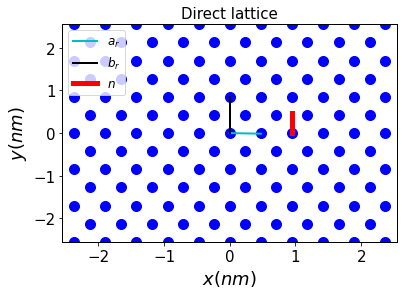

In [106]:
#Opening angle gamma
gammar= umath.acos((Qxy1bar1r**2-Qxy11r**2)/(Qxy02r*umath.sqrt(2*Qxy1bar1r**2+2*Qxy11r**2-Qxy02r**2)))
print('gammar (deg) =', gammar*180./pi)

#ar and br
br = 4*pi/(Qxy02r*umath.sin(gammar))

ar = 4*pi/(umath.sqrt(2*Qxy1bar1r**2+2*Qxy11r**2-Qxy02r**2)*umath.sin(gammar))

print('ar (nm) = ', ar)
print('br (nm) = ', br)


blob = (1./umath.sin(gammar))*( (qz11r+qz1bar1r)*ar/(qz02r*br) +umath.cos(gammar) )
psi = umath.atan(1/blob)
print('psi (deg) =', psi*180/pi)

t = umath.atan( -ar*umath.sin(gammar)/(4*pi) * (qz11r+qz1bar1r)/(umath.cos(psi)*umath.sin(gammar)-umath.cos(gammar)*umath.sin(psi)) )
print('t (deg) = ', t*180/pi)



#FOR PLOTTING THE STRUCTURE
ar = ar.nominal_value
br = br.nominal_value
gammar = gammar.nominal_value
t = t.nominal_value
psi = psi.nominal_value



beta = pi-gammar
a = 1./2*np.sqrt((br**2+ar**2-2*br*ar*np.cos(beta)))
b = np.sqrt((ar**2+br**2-2*ar*br*np.cos(gammar))/4)
omega = np.arccos((a**2+br**2-b**2)/(2*a*br))
tau = np.arccos((-br**2+ar**2+4*b**2)/(4*ar*b))
    

y1 = np.sin(omega)*a
x1 = np.cos(omega)*a

x_dots = [j*x1 + i*br for j in range(-20,20) for i in range(-20,20)]
y_dots = [y1*j for j in range(-20,20) for i in range(-20,20)]



fig, ax = plt.subplots()
plt.plot(y_dots, x_dots,'bo', markersize = 10)
plt.xlim(-3*br,3*br)
plt.ylim(-3*br,3*br)

plt.plot([0,ar*np.sin(gamma)],[0,ar*np.cos(gamma)], 'c', label = '$a_r$', lw = 2)
#plt.plot([0,y1],[0,x1], 'c--', label = '$a_h$', lw = 2)

plt.plot([0,0],[0,br], 'k', label = '$b_r$', lw = 2)
#plt.plot([0,b*np.sin(beta-tau)],[0,-b*np.cos(beta-tau)], 'k--', label = '$b_h$', lw = 2)

if ~np.isclose(t,0):
    plt.plot([0+2*ar,ar*np.cos(psi)+2*ar],[0,ar*np.sin(psi)], 'r', label = '$n$', lw = 5)


plt.legend(fontsize=12, loc='upper left')


plt.xlabel("$x (nm)$", fontsize=18)
plt.ylabel("$y (nm)$", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Direct lattice', fontsize = 15)
plt.legend(fontsize=12, loc='upper left')


plt.show()
plt.close()